In [125]:
%pylab inline

import pandas as pd
import numpy as np

from itertools import combinations

from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

import datetime, time

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [142]:
# read data
wnv_train = pd.read_csv('../working/train_f.csv', index_col=0)
wnv_test = pd.read_csv('../working/test_f.csv', index_col=0)

In [143]:
labels = pd.Series(wnv_train['WnvPresent'].values.astype(int), index=wnv_train.index)
wnv_train.drop('NumMosquitos', axis=1, inplace=True)
wnv_train.drop('WnvPresent', axis=1, inplace=True)

In [144]:
# setup kfold
years = np.unique(wnv_train['Year'])
kf = KFold(len(years), n_folds=2)

for train_index, test_index in kf:
    print("TRAIN:", years[train_index], "TEST:", years[test_index])

('TRAIN:', array([2011, 2013], dtype=int64), 'TEST:', array([2007, 2009], dtype=int64))
('TRAIN:', array([2007, 2009], dtype=int64), 'TEST:', array([2011, 2013], dtype=int64))


In [147]:
# combinations approach
yc = list(itertools.combinations(years, 3))
train_years = [list(c) for c in yc]
#test_years = [list(set(years) - set(c)) for c in yc]
print train_years

[[2007, 2009, 2011], [2007, 2009, 2013], [2007, 2011, 2013], [2009, 2011, 2013]]


AUC validating with year(s) [2013]: 0.649818196659
AUC validating with year(s) [2011]: 0.70931836351
AUC validating with year(s) [2009]: 0.550790653764
AUC validating with year(s) [2007]: 0.511619058907


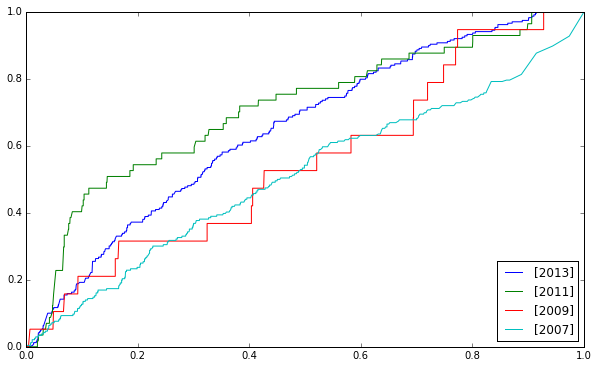

In [149]:
# classifier
clf = ExtraTreesClassifier(n_estimators=5000, n_jobs=3)
#clf = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=10, scoring='mean_squared_error')

plt.figure(figsize=(10,6))
# iterate through years
for ty in train_years:
    # inverse of year list
    yt = list(set(years) - set(ty))
    
    # get raw data
    train_mask = wnv_train['Year'].isin(ty)
    test_mask = wnv_train['Year'].isin(yt)
    Xr_train = wnv_train[train_mask].values.astype('float64')
    Xr_test = wnv_train[test_mask].values.astype('float64')
    y_train = labels.loc[train_mask].values
    y_test = labels.loc[test_mask].values
    
    # normalize
    scaler = StandardScaler()
    scaler.fit(Xr_train)
    Xn_train = scaler.transform(Xr_train)
    Xn_test = scaler.transform(Xr_test)
    
    # train classifier
    clf.fit(Xn_train, y_train)
    
    # predict labels
    proba = clf.predict_proba(Xn_test)
    #proba = clf.predict(Xn_test)
    
    # metrics
    fpr, tpr, thresholds = roc_curve(y_test, proba[:, 1])
    #fpr, tpr, thresholds = roc_curve(y_test, proba)
    score = auc(fpr, tpr)
    print 'AUC validating with year(s)', str(yt) + ':', score
    
    # plot
    plt.plot(fpr, tpr, label=yt)

plt.legend(loc=4)

In [151]:
# train on full data
Xr_train = wnv_train.values.astype('float64')
Xr_test = wnv_test.values.astype('float64')
y_train = labels.values

# normalize
scaler = StandardScaler()
scaler.fit(Xr_train)
Xn_train = scaler.transform(Xr_train)
Xn_test = scaler.transform(Xr_test)

# train classifier
clf.fit(Xn_train, y_train)

# predict labels
proba = clf.predict_proba(Xn_test)

In [152]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S')

def write_preds(proba, fname):
    pd.DataFrame({"Id": list(range(1,len(proba)+1)), "WnvPresent": proba}).to_csv(fname, index=False, header=True)

write_preds(proba[:,1], "../working/kfold_test_" + st + ".csv")